<a href="https://colab.research.google.com/github/theAkhileshRai/ComputerVision/blob/master/AnchorBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#FineTuning


!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2lm

Requirement already up-to-date: mxnet-cu101mkl in /usr/local/lib/python3.6/dist-packages (1.6.0)
  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-jzzk0cy1
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-jzzk0cy1
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31756 sha256=68f4afe02bb5b36557909a5a94a94d0bb85ee2e2305f6c187b46ca6253d2516e
  Stored in directory: /tmp/pip-ephem-wheel-cache-cvo_98nr/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l


In [0]:
%matplotlib inline
import d2l
from mxnet import contrib, gluon, image, np, npx

np.set_printoptions(2)
npx.set_np()

In [31]:
img = image.imread('/content/catdog.jpg').asnumpy()
h, w = img.shape[0:2]

print(h, w)
X = np.random.uniform(size=(1, 3, h, w))  # Construct input data
Y = npx.multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


(1, 2042040, 4)

In [32]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

array([0.06, 0.07, 0.63, 0.82])

In [0]:
# Saved in the d2l package for later use
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

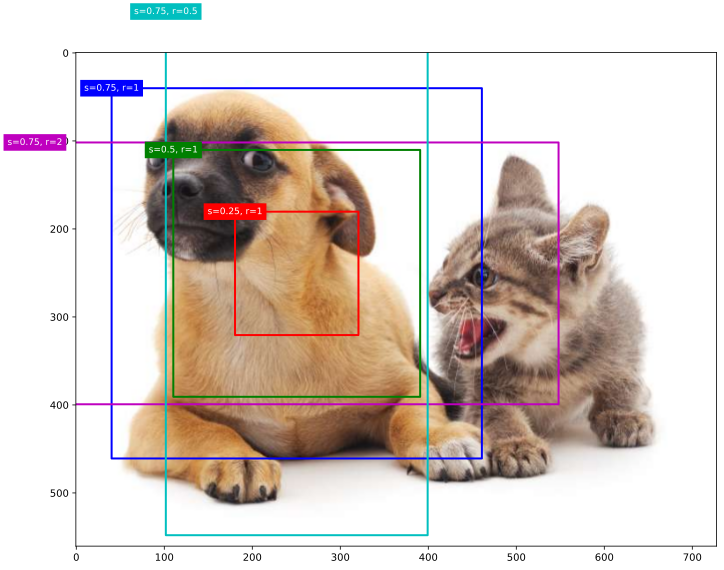

In [34]:
d2l.set_figsize((11.5, 12.5))
bbox_scale = np.array((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

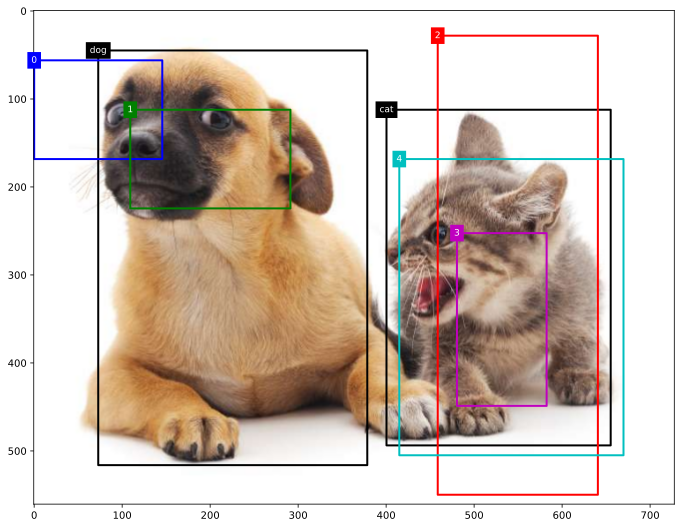

In [35]:
ground_truth = np.array([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = np.array([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])

In [0]:
labels = npx.multibox_target(np.expand_dims(anchors, axis=0),
                             np.expand_dims(ground_truth, axis=0),
                             np.zeros((1, 3, 5)))

In [37]:
labels[2]

array([[0., 1., 2., 0., 2.]])

In [0]:
anchors = np.array([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                    [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = np.array([0] * anchors.size)
cls_probs = np.array([[0] * 4,  # Predicted probability for background
                      [0.9, 0.8, 0.7, 0.1],  # Predicted probability for dog
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted probability for cat

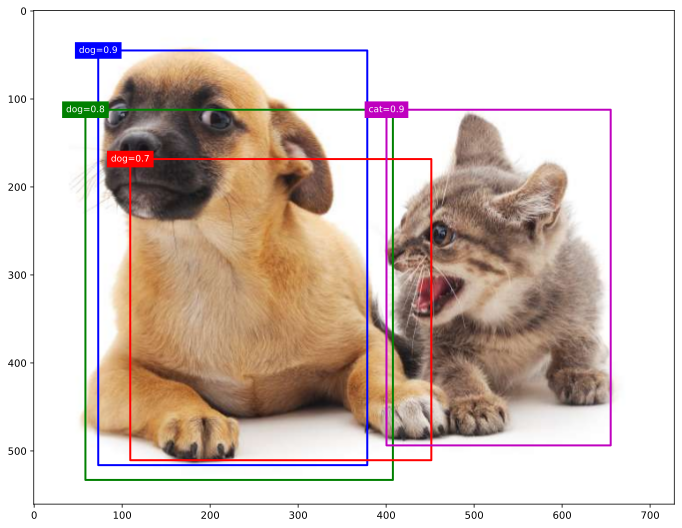

In [39]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [40]:
output = npx.multibox_detection(
    np.expand_dims(cls_probs, axis=0),
    np.expand_dims(offset_preds, axis=0),
    np.expand_dims(anchors, axis=0),
    nms_threshold=0.5)
output

array([[[ 0.  ,  0.9 ,  0.1 ,  0.08,  0.52,  0.92],
        [ 1.  ,  0.9 ,  0.55,  0.2 ,  0.9 ,  0.88],
        [-1.  ,  0.8 ,  0.08,  0.2 ,  0.56,  0.95],
        [-1.  ,  0.7 ,  0.15,  0.3 ,  0.62,  0.91]]])

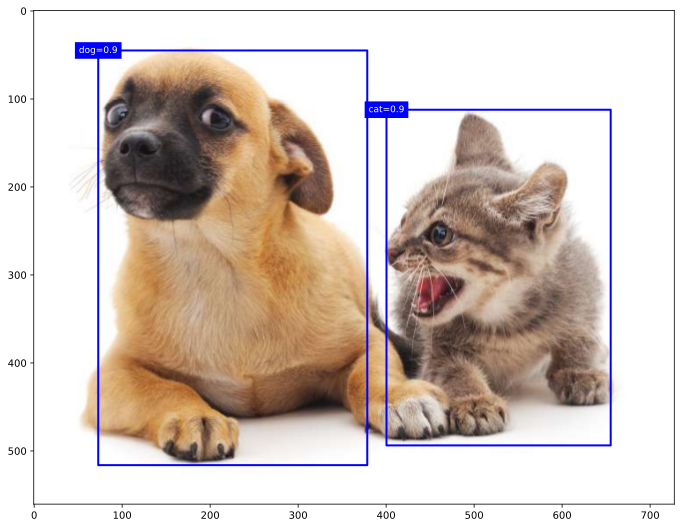

In [41]:
fig = d2l.plt.imshow(img)
for i in output[0].asnumpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [np.array(i[2:]) * bbox_scale], label)